In [1]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt


## Get square corners using openCV function

In [3]:

checker_h = 9  # Horizontal lines
checker_v = 7  # Vertical lines
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((checker_v*checker_h, 3), np.float32)
objp[:, :2] = np.mgrid[0:checker_h, 0:checker_v].T.reshape(-1, 2)
# Arrays to store object points and image points from all the images.
objpoints = []  # 3d point in real world space
imgpoints = []  # 2d points in image plane.
# images = glob.glob('./imgs2/*.jpg')
images = glob.glob('./imgs/*.jpg')
allCorners = []

for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (checker_h, checker_v), None)
    # print(corners)
    # print(type(corners))
    # print(corners.shape)
    allCorners.append(corners)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (checker_h, checker_v), corners2, ret)
        # cv.imshow('img', img)
        # plt.imshow(img)
        # plt.show()
        # cv.waitKey(1000)
cv.destroyAllWindows()


## Keep first 4 coresponding corners

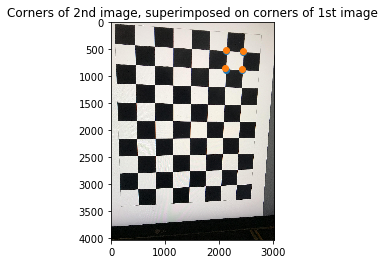

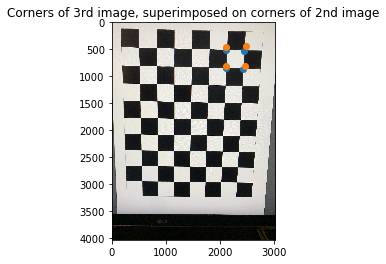

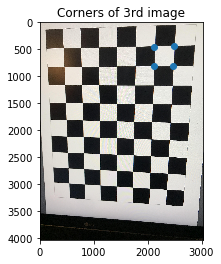

In [27]:

#THis function will return first 4 non co-linear corners from the corners found in the previous cell
def getFirstFourPoints(corners):
    first2 =  np.vstack((corners.reshape((corners.shape[0], 2))[:2, 0], corners.reshape((corners.shape[0], 2))[:2, 1])).T
    last2 = np.vstack((corners.reshape((corners.shape[0], 2))[9:11, 0], corners.reshape((corners.shape[0], 2))[9:11, 1])).T
    return np.vstack((first2, last2))



pts1 = getFirstFourPoints(allCorners[1])
pts2 = getFirstFourPoints(allCorners[2])
pts3 = getFirstFourPoints(allCorners[0])

#List to store first four corners from each image
myPts = []

img = plt.imread(
    '/home/pascal/Computer_Vision/Recovering_cam_motion/imgs/1.jpg')
plt.imshow(img)
myPts.append(pts1)
plt.scatter(pts1[:,0], pts1[:,1])
plt.scatter(pts2[:, 0], pts2[:, 1])
# plt.scatter(pts3[:, 0], pts3[:, 1])
plt.title('Corners of 2nd image, superimposed on corners of 1st image')

plt.show()

img = plt.imread(
    '/home/pascal/Computer_Vision/Recovering_cam_motion/imgs/2.jpg')
plt.imshow(img)
myPts.append(pts2)
plt.scatter(pts2[:, 0], pts2[:, 1])
plt.scatter(pts3[:, 0], pts3[:, 1])
plt.title('Corners of 3rd image, superimposed on corners of 2nd image')
plt.show()

# img = plt.imread('/home/pascal/Computer_Vision/Recovering_cam_motion/imgs2/1.jpg')
img = plt.imread('/home/pascal/Computer_Vision/Recovering_cam_motion/imgs/3.jpg')
plt.imshow(img)
myPts.append(pts3)
plt.scatter(pts3[:, 0], pts3[:, 1])
plt.title('Corners of 3rd image')
plt.show()
# allCorners[0].reshape((63, 2))


## Functions to calculate homography and extrinsic parameters. Follows algo 15.6 in princes_algorithms book

In [21]:
def getAmatrix(X, W):
    i = 0
    A = np.zeros((W.shape[0]*2, 9))

    for w,xy in zip(W, X):
        u = w[0]
        v = w[1]

        x = xy[0]
        y = xy[1]

        A[i] = np.array([0,0,0,-u, -v, -1, y*u, u*v, y])
        A[i+1] = np.array([u,v,1,0,0,0,-x*u, -x*v, -x])

        i+=2
    return A


def calculateHomography(A):
    u, s, vh = np.linalg.svd(A)
    V = vh.T
    phi = V[:, -1]  # Take last column as explained in the book
    return phi.reshape((3, 3))


def calculateExtrinsicParams(Lambda, hom):
    #Calculate extrinsic parameters (Following algo 15.6 in princes_algorithms)
    Phi = np.linalg.inv(Lambda) @ hom
    u, s, vh = np.linalg.svd(Phi[:, :2])
    # Estimate first two columns of rotation matrix
    w12 = u[:, :2] @ vh.T
    w1 = w12[:, 0]
    w2 = w12[:, 1]
    # Estimate third column by taking cross product
    w3 = np.cross(w1, w2)
    Omega = np.vstack((w1, w2, w3))

    # Check that determinant is not minus 1
    if np.linalg.det(Omega) < 0:
        print('neg det')
        Omega[2, :] *= -1

    # Compute scaling factor for translation vector
    scale = 1/6*np.sum(Omega/Phi)
    # Compute translation
    tau = scale*Phi[:, -1]
    return Omega, tau



def estimateExtrinsicParams(X,W,Lambda):
    A = getAmatrix(X, W)

    hom = calculateHomography(A)
    
    return calculateExtrinsicParams(Lambda, hom)


def getTransRotMat(rot, t):
    rot_aug = np.zeros((4, 4))
    rot_aug[:3, :3] = rot
    rot_aug[-1, -1] = 1
    rot_aug[:3,-1] = t # Add translations
    return rot_aug


## Applying extrinsic paramters estimation to corners

In [36]:
X = myPts[1] #Using 2nd image (picture from center) as image coordinates
W = myPts[0] 



phi_x = 3329.6513117460936
phi_y = 3335.682059858252
skew = 0
sigma_x = 1527.8832108670595
sigma_y = 1974.7470364946348

Lambda = np.array([[phi_x, skew, sigma_x],
                   [0, phi_y, sigma_y],
                   [0, 0, 1]])

Om1, t1 = estimateExtrinsicParams(X, W, Lambda)
# Om1, t1 = estimateExtrinsicParams(W, X, Lambda)
print(f'Omega1 = \n{Om1}')
print(f'tau1 = \n{t1}')

transRot1 = getTransRotMat(Om1, t1)
# print(f'transRot1 = \n{transRot1}')
# Om_aug

# X = myPts[1]
W = myPts[2]

Om2, t2 = estimateExtrinsicParams(X, W, Lambda)
# Om2, t2 = estimateExtrinsicParams(W, X, Lambda)
print(f'Omega2 = \n{Om2}')
print(f'tau2 = \n{t2}')

transRot2 = getTransRotMat(Om2, t2)
# print(f'transRot2 = \n{transRot2}')


Omega1 = 
[[-0.41704804 -0.90841355  0.02925312]
 [ 0.89449009 -0.41593595 -0.16396577]
 [ 0.16111615 -0.04221497  0.98603219]]
tau1 = 
[ 27274.13024505  36852.65392107 -65139.66481951]
Omega2 = 
[[ 0.57355521 -0.80550992  0.14895705]
 [ 0.79408277  0.59137732  0.14037598]
 [-0.20116407  0.03777085  0.97882909]]
tau2 = 
[-11351.80835481 -14435.98331262  23778.57541085]


## Visualization

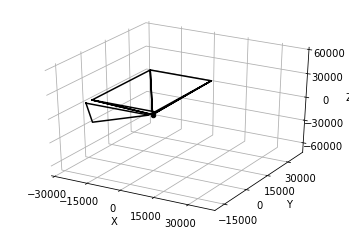

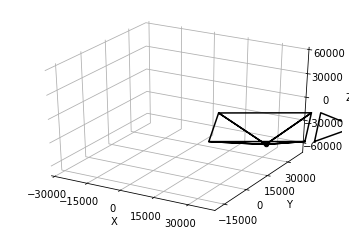

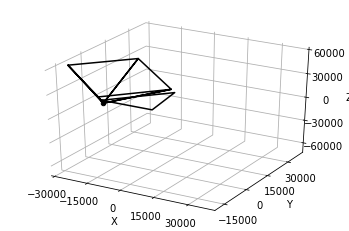

In [37]:
import pytransform3d.camera as pc
import pytransform3d.transformations as pt


# cam2world = pt.transform_from_pq([0, 0, 0, np.sqrt(0.5), -np.sqrt(0.5), 0, 0])
cam2world = pt.transform_from_pq([0, 0, 0, 0, 0, 0, 0])
# print(f'Cam2world : \n{cam2world}')
# default parameters of a camera in Blender
# sensor_size = np.array([0.036, 0.024])
# sensor_size = np.array([4032, 3024])
sensor_size = np.array([3024, 4032])
# intrinsic_matrix = np.array([
#     [0.05, 0, sensor_size[0] / 2.0],
#     [0, 0.05, sensor_size[1] / 2.0],
#     [0, 0, 1]
# ])

intrinsic_matrix = Lambda
virtual_image_distance = 30000

# ax = pt.plot_transform(A2B=cam2world, s=0.2)
# transRot2
ax = pt.plot_transform(A2B=cam2world, s=0.2)
ax.set_xlim(-30000, 40000)
ax.set_ylim(-20000, 40000)
ax.set_zlim(-70000, 60000)

pc.plot_camera(
    ax, cam2world=cam2world, M=intrinsic_matrix, sensor_size=sensor_size,
    virtual_image_distance=virtual_image_distance)
plt.show()


ax = pt.plot_transform(A2B=transRot1, s=0.2)
ax.set_xlim(-30000, 40000)
ax.set_ylim(-20000, 40000)
ax.set_zlim(-70000, 60000)
pc.plot_camera(
    ax, cam2world=transRot1, M=intrinsic_matrix, sensor_size=sensor_size,
    virtual_image_distance=virtual_image_distance)

plt.show()

ax = pt.plot_transform(A2B=transRot2, s=0.2)
ax.set_xlim(-30000, 40000)
ax.set_ylim(-20000, 40000)
ax.set_zlim(-70000, 60000)
pc.plot_camera(
    ax, cam2world=transRot2, M=intrinsic_matrix, sensor_size=sensor_size,
    virtual_image_distance=virtual_image_distance)

# print(f'transRot2 = \n{transRot2}')
plt.show()
